In [1]:
import numpy as np
from scipy.stats import invgamma
from scipy.stats import norm

import pandas as pd

In [2]:
data = pd.read_csv("HistoricalData.csv").set_index("Date")
btc_open = data["Open"]
print(data.columns)
btc_open

Index(['Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')


Date
01/28/2024    42717.5
01/27/2024    41840.9
01/26/2024    39936.2
01/25/2024    39948.4
01/24/2024    39654.2
               ...   
03/12/2019     3870.3
03/11/2019     3915.6
03/10/2019     3944.3
03/09/2019     3865.9
03/08/2019     3875.1
Name: Open, Length: 1717, dtype: float64

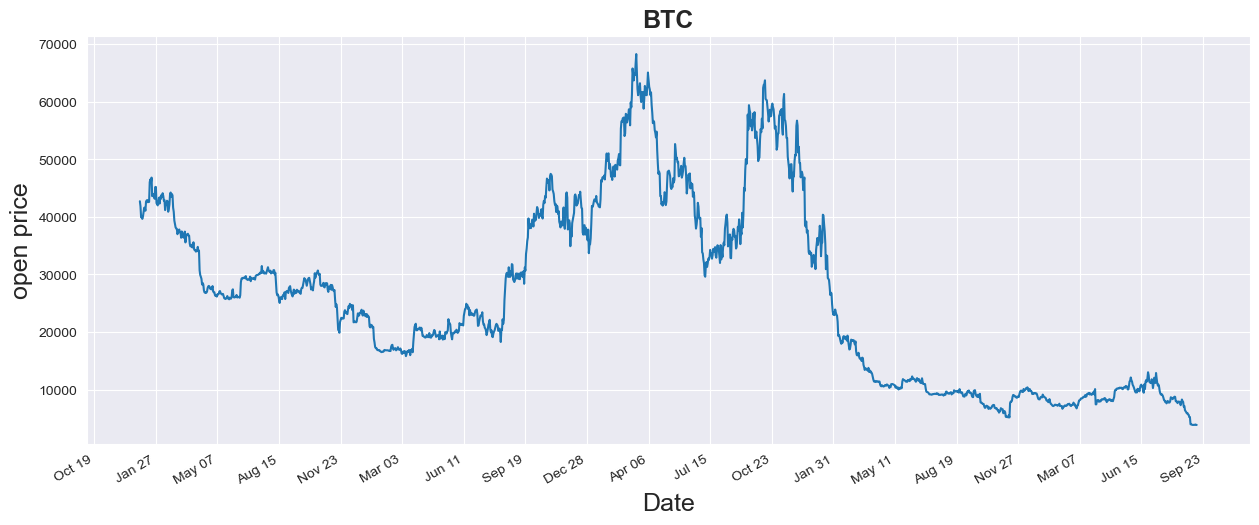

In [3]:
from utils import visualize

visualize.draw(btc_open, ylabel="open price")

## Daily Return 

$$
R_i=\frac{o_{i+1}-o_{i}}{o_{i}}
$$

In [4]:
data["Return"] = (data["Open"].shift(1) - data["Open"])/data["Open"]
data["Return"] = data["Return"].fillna(0)

data["Return"]

Date
01/28/2024    0.000000
01/27/2024    0.020951
01/26/2024    0.047694
01/25/2024   -0.000305
01/24/2024    0.007419
                ...   
03/12/2019    0.004470
03/11/2019   -0.011569
03/10/2019   -0.007276
03/09/2019    0.020280
03/08/2019   -0.002374
Name: Return, Length: 1717, dtype: float64

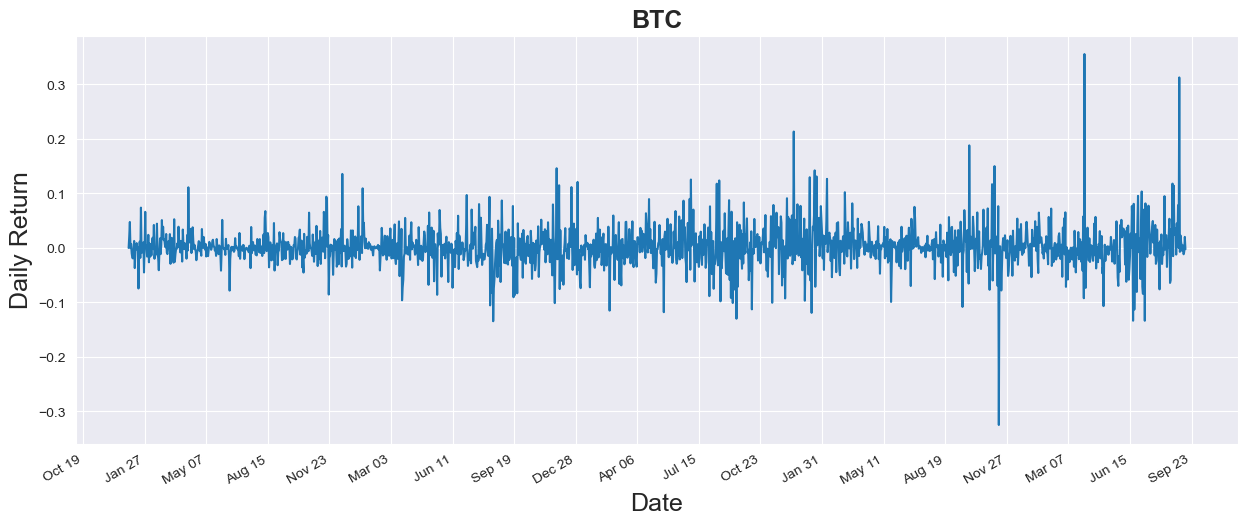

In [5]:
visualize.draw(data["Return"], ylabel="Daily Return")

### Log Returns

$$
R^L_i=\ln (\frac{o_{i+1}}{o_i})
$$

In [6]:
data["Log"] = np.log(data["Open"].shift(1)/data["Open"])
data["Log"] = data["Log"].fillna(0)

data["Log"]

Date
01/28/2024    0.000000
01/27/2024    0.020734
01/26/2024    0.046591
01/25/2024   -0.000305
01/24/2024    0.007392
                ...   
03/12/2019    0.004460
03/11/2019   -0.011637
03/10/2019   -0.007303
03/09/2019    0.020077
03/08/2019   -0.002377
Name: Log, Length: 1717, dtype: float64

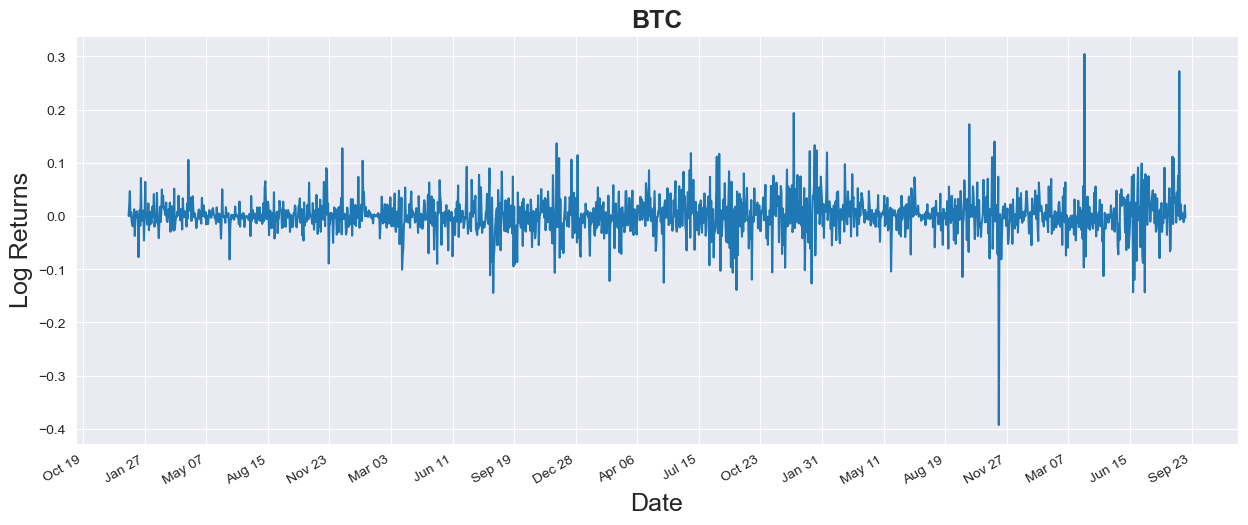

In [7]:
visualize.draw(data["Log"], ylabel="Log Returns")

In [8]:
mean_ = data["Log"].mean()
sum_ = data["Log"].sum()
sigma2_ = data["Log"].std()**2
n_ = data["Log"].size

print(mean_, sum_, sigma2_, n_)

0.0013978085051929805 2.4000372034163457 0.0013749970883640916 1717


# Gibbs Sampling

- references:
    - https://www.youtube.com/watch?v=dclTzszTMNQ

our data, daily returns are following normal distribution, with unknown parameters $\mu$ and $\sigma^2$.

$$
R\sim N(\mu,\sigma^2)
$$

further, we assume $\mu$ follows another normal distribution:

$$
\mu \sim N(\mu_0, \sigma_0^2),~f(\mu|\mu_o,\sigma_0^2)=\frac1{\sqrt{2\pi\sigma_0^2}}e^{-\frac12(\frac{\mu-\mu_0}{\sigma_0})^2}
$$

and we assume $\sigma^2$ follows a inverse Gamma square distribution:

$$
\sigma^2 \sim inv-Ga(\alpha, \beta),~f(\sigma^2|\alpha,\beta)=\frac 1{\Gamma(\alpha)}\frac{\beta^\alpha}{\sigma^{2\alpha+2}}e^{-\beta/\sigma^2}
$$

In [9]:
from utils import distributions

In [14]:
mu_l = []
sigma2_l = []

with given data, we could derive the posterior conditional distribution for these two parameters:

$$
\mu| X \sim N({\sigma^2\mu_0+\sigma_0^2 n\bar x\over\sigma^2+n\sigma_0^2},{\sigma^2\sigma_0^2\over\sigma^2+n\sigma_0^2})
$$

$$
\sigma^2| X \sim inv-Ga(\alpha+\frac n2,\beta+\frac{n\bar x}2)
$$

In [21]:
import numpy as np
from scipy.stats import invgamma
import matplotlib.pyplot as plt

In [22]:
def sample_gaus(_mu0, _n, _mean, _sigma2, _sigma02):
    dom = _sigma2+_n*_sigma02
    return np.random.normal(loc=(_sigma2*_mu0+_sigma02*_n*_mean)/dom, scale=np.sqrt(_sigma2*_sigma02)/dom, size=1)

def sample_invGa(_alpha, _beta, _n, _mean):
    return invgamma.rvs(_alpha+_n/2, scale=_beta+_n*_mean/2, size=1)

In [23]:
samples = 1000

mu = mean_
sigma2 = sigma2_

mu_0 = mu
sigma_02 = 100

alpha = 10
beta = 0.5

for i in range(samples):
    
    mu = sample_gaus(mu_0, n_, mean_, sigma2, sigma_02)
    sigma2 = sample_invGa(alpha,beta,n_,mean_)
    
    mu_l += [mu]
    sigma2_l += [sigma2]
    

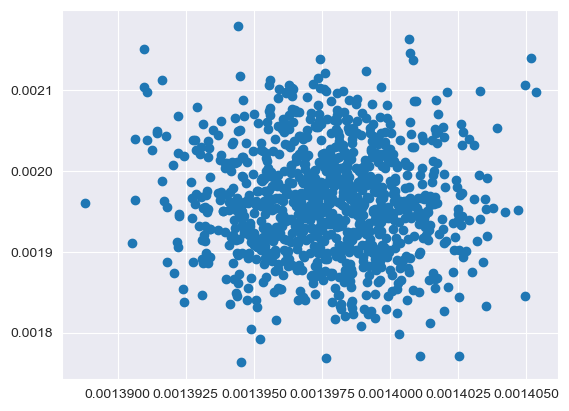

In [24]:
plt.scatter(x=mu_l,y=sigma2_l)

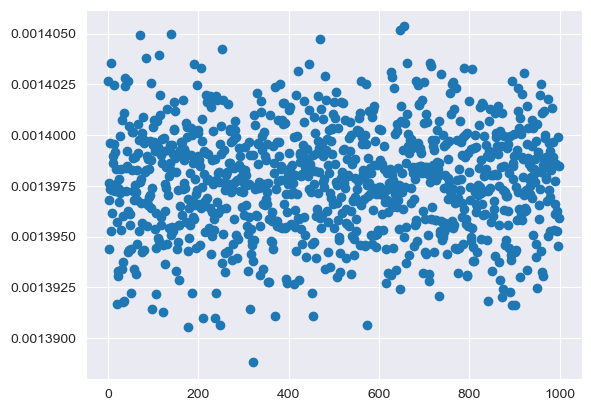

In [30]:
plt.scatter(x=range(len(mu_l)), y=mu_l)

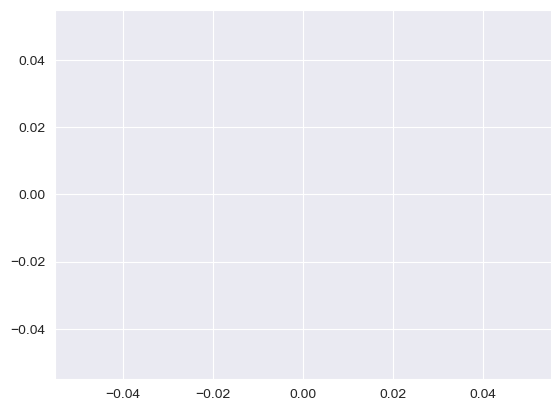

In [49]:
plt.hist(mu_l, bins=np.arange(0.00139, 0.001405, 0.0001), edgecolor='black')
plt.show()

In [50]:
Running Mean

SyntaxError: invalid syntax (3382161302.py, line 1)

In [ ]:
Creditable Interval
Auto correlation -> 0